## ON THE PLURALITY OF GRAPHS

Small _network-based_ playground to create sample graphs on which to play Lewis signaling games ;-)

### Installation and imports

_First make sure we have networkx updated as v 2.0 had some API changes and we want to avoid troubles_

In [1]:
# ! pip install networkx --upgrade

_Install also the nice powerlaw package if we want to run also the power law analysis_

In [2]:
# ! pip install powerlaw

In [3]:
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
import numpy as np
from random import choice
from scipy.special import softmax
from collections import Counter
import math

In [4]:
%matplotlib inline

### Simulation variables

In [5]:
N_NODES = 1000
NETWORK_PARAMS = dict()

Settings for barabasi-albert graph - scale free with pref attachment

https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html?highlight=barabasi_albert_graph#networkx.generators.random_graphs.barabasi_albert_graph

In [6]:
NETWORK_PARAMS['barabasi'] = [N_NODES, 5] 

Settings for Erdős–Rényi model - random graph

https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html?highlight=erdos_renyi_graph#networkx.generators.random_graphs.erdos_renyi_graph

In [7]:
NETWORK_PARAMS['erdos'] = [N_NODES, 0.15]

Settings for the Watts–Strogatz - "small-world graph", including short average path lengths and high clustering (six-degrees of separation kind of thing) 

https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html?highlight=watts_strogatz_graph#networkx.generators.random_graphs.watts_strogatz_graph

In [8]:
NETWORK_PARAMS['watts'] = [N_NODES, 3, 0.1]

### Some graph / chart / stats utils functions

In [9]:
def draw_network(nx_graph, node_color='black', node_size=100, width=3):
    options = {
        'node_color': node_color,
        'node_size': node_size,
        'width': width
    }
    nx.draw(nx_graph, with_labels=True, font_weight='bold', **options)
    plt.show()

In [10]:
def get_all_degrees(nx_graph):
    return [d for n, d in nx_graph.degree()]

In [11]:
def plot_distribution(nx_graph, bins=20, label='My Graph'):
    """
    Convenient function that retrieves all degree and bins them to visualize distribution
    """ 
    all_degrees = get_all_degrees(nx_graph)
    plt.hist(all_degrees, bins=bins)
    plt.title("Frequency Distribution for {}".format(label))
    plt.show()

In [12]:
def fit_power_law_to_data(data, alternative_distribution='lognormal', target_file=None):
    """
    Use fantastic powerlaw package based on SFI paper -> https://arxiv.org/pdf/1305.0215.pdf
    """
    # fit a discrete powerlaw here
    results = powerlaw.Fit(data, discrete=True)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p = results.distribution_compare('power_law', alternative_distribution, normalized_ratio=True)
    fig2 = results.plot_ccdf(color='b', linewidth=2)
    results.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
    # save to disk if a path is specified
    if target_file:
        fig2.figure.savefig(target_file)
    
    return alpha, xmin, R, p, results.truncated_power_law.alpha

### Interlude: Test out networkx general functions

First, test out networkx generation capabilities on two types of graphs

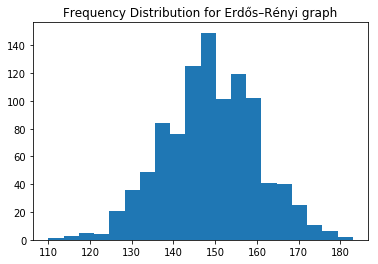

In [13]:
# generate graph with params
er = nx.erdos_renyi_graph(*NETWORK_PARAMS['erdos'])
# plot distribution
plot_distribution(er, bins=20, label='Erdős–Rényi graph')

4975


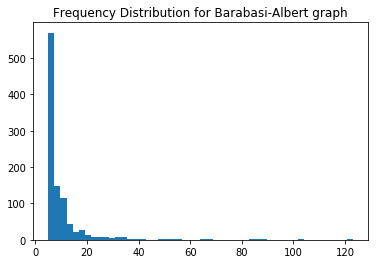

In [14]:
# generate graph with params
ba = nx.barabasi_albert_graph(*NETWORK_PARAMS['barabasi'])
print(ba.number_of_edges())
# plot distribution
plot_distribution(ba, bins=50, label='Barabasi-Albert graph')
# fit a powerlaw

_Check degree distribution using the nice powerlaw package from http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0085777_

Calculating best minimal value for power law fit
/Users/jacopotagliabue/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/jacopotagliabue/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Alpha value for p-law: 2.7034785342246557
Loglikelihood ratio between the two candidate distributions is 4.972613238884785, favoring powerlaw
The significance value for the ratio is 6.605636265826152e-07


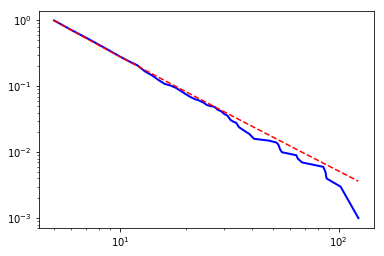

In [15]:
# check goodness of fit against a natural candidate -> see https://arxiv.org/pdf/1305.0215.pdf
alternative_distribution = 'exponential'
alpha, xmin, R, p, t_alpha = fit_power_law_to_data(get_all_degrees(ba), alternative_distribution=alternative_distribution)
print("Alpha value for p-law: {}".format(alpha))
print("Loglikelihood ratio between the two candidate distributions is {}, favoring {}".format(R,
                                                                                             'powerlaw' if R > 0.0 else alternative_distribution))
print("The significance value for the ratio is {}".format(p))

_As expected, the BA network is well-represented by the power-law distribution for degrees_

Finally, not exactly fancy, but try to draw a small graph in case we need some charts later on...

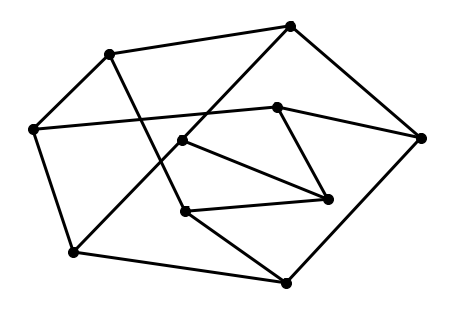

In [16]:
g = nx.petersen_graph()
draw_network(g)

### Generating networks and sampling strategies

In [17]:
def pick_random_nodes(nodes, n=1, weights=None):
    """
    Return N nodes, if weights is specified choose the nodes with proportional probabilities
    """
    # probabilities needs to sum up to 1...
    probs = softmax(weights) if weights else None
    return np.random.choice(nodes, n, p=probs)

In [18]:
def get_network_by_type_and_settings(network_type, network_settings):
    """
    Network type must be one of: erdos, watts, barabasi
    """
    if network_type == 'erdos':
        return nx.erdos_renyi_graph(*network_settings)
    elif network_type == 'watts':
        return nx.connected_watts_strogatz_graph(*network_settings)
    elif network_type == 'barabasi':
        return nx.barabasi_albert_graph(*network_settings)
    else:
        raise Exception("Unknown type: {}".format(network_type))

In [19]:
def calculate_network_centrality(nx_graph, centrality_metrics):
    """
    centrality_metrics must be one of 'degree', 'pagerank', 'betweeness'
    
    return type is always a dict(node->measure of centrality)
    """
    if centrality_metrics == 'degree':
        return nx.degree_centrality(nx_graph)
    elif centrality_metrics == 'betweeness':
        return nx.betweenness_centrality(nx_graph)
    elif centrality_metrics == 'pagerank':
        return nx.pagerank_numpy(nx_graph)
    else:
        raise Exception("Unknown metrics: {}".format(centrality_metrics))

In [20]:
# list options
NETWORK_TOPOLOGIES = ['erdos', 'watts', 'barabasi']
# pick one randomly here
current_topology = choice(NETWORK_TOPOLOGIES)
# list options
CENTRALITY_MEASURES = ['degree', 'pagerank', 'betweeness']
# pick one randomly here
current_centrality_measure = choice(CENTRALITY_MEASURES)
print("Chosen topology is: {}, with params: {} and centrality: {}".format(current_topology, 
                                                                          NETWORK_PARAMS[current_topology],
                                                                          current_centrality_measure))

Chosen topology is: erdos, with params: [1000, 0.15] and centrality: betweeness


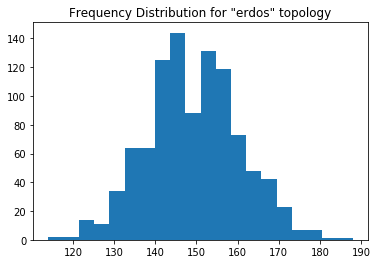

0 0.0008324054632061739
1 0.0009189749107172922
2 0.0007926349034274502
3 0.0008798457679345731
4 0.000625970246449354
5 0.0009529759829945856
6 0.0009785121380216076
7 0.0009427608930042217
8 0.000921417253780342
9 0.0008691381492504577


In [21]:
# generate network
current_network = get_network_by_type_and_settings(current_topology, NETWORK_PARAMS[current_topology])
# plot distribution
plot_distribution(current_network, bins=20, label='"{}" topology'.format(current_topology))
# get centrality
node_2_centrality = calculate_network_centrality(current_network, current_centrality_measure)
# print out some sample centrality values for debug
for n in list(node_2_centrality.keys())[:10]:
    print(n, node_2_centrality[n])

In [22]:
def sample_neighbors_of_node(nx_graph, source_node, topn=1):
    """
    Get neighboring nodes and then return N random ones up until the topn
    """
    neighbors = [n for n in nx_graph.neighbors(source_node)]
    # we shouldn't have disconnected graphs, but check to avoid weird things..
    assert len(neighbors) > 0
    
    # check N are not less than the requested amount
    if topn >= len(neighbors):
        return neighbors
    
    # return random subset
    return np.random.choice(neighbors, topn, replace=False)

In [23]:
def sample_pair_randomly(nx_graph, verbose=False):
    first_node = pick_random_nodes(list(nx_graph.nodes))[0]
    second_node = sample_neighbors_of_node(nx_graph, first_node)[0]
    if verbose:
        print("Sampled {} and {}".format(first_node, second_node))
    
    return (first_node, second_node)

# just run it once
sample_pair_randomly(current_network)

(118, 736)

In [24]:
def sample_pair_through_centrality(nx_graph, node_2_centrality):
    # think about passing directly the node list if we need to do it a lot...
    node_list = list(nx_graph.nodes)
    weights = [node_2_centrality[n] for n in node_list]
    first_node = pick_random_nodes(node_list, n=1, weights=weights)[0]
    second_node = sample_neighbors_of_node(nx_graph, first_node)[0]
    
    return (first_node, second_node)

# just run it once
sample_pair_through_centrality(current_network, node_2_centrality)

(321, 563)

_As a numerical test run 1000 times the centrality one for two networks and check how distributions get skewed..._

In [25]:
for test_network_type in ['barabasi', 'erdos']:
    test_network = get_network_by_type_and_settings(test_network_type, NETWORK_PARAMS[test_network_type])
    test_node_2_centrality = calculate_network_centrality(test_network, 'pagerank')
    # run the sampling 100 times...
    sampled_pairs = [sample_pair_through_centrality(test_network, test_node_2_centrality) for _ in range(1000)]
    # flatten the pairs and count them 
    cnt_nodes = Counter([item for sublist in sampled_pairs for item in sublist])
    print("\n{} most sampled pairs:".format(test_network_type))
    print(cnt_nodes.most_common(10))


barabasi most sampled pairs:
[(6, 17), (7, 15), (11, 13), (1, 12), (9, 11), (14, 10), (120, 10), (39, 9), (272, 9), (149, 9)]

erdos most sampled pairs:
[(513, 8), (208, 7), (800, 7), (572, 7), (658, 6), (313, 6), (236, 6), (645, 6), (217, 6), (117, 6)]


_Now test the sampling function always returns data as expected running them with different configs and network_

In [26]:
TEST_SIZE = 10
for n_t in NETWORK_TOPOLOGIES:
    for c_m in CENTRALITY_MEASURES:
        print(n_t, c_m)
        c_network = get_network_by_type_and_settings(n_t, NETWORK_PARAMS[n_t])
        n_2_centrality = calculate_network_centrality(c_network, c_m)
        for _ in range(TEST_SIZE):
            # half the time, sample with centrality, half the time randomly
            if _ % 2 == 0:
                s_pair = sample_pair_through_centrality(c_network, n_2_centrality)
            else:
                s_pair = sample_pair_randomly(c_network)
            # check we have results
            assert len(s_pair) == 2 and all(s is not None for s in s_pair)

erdos degree
erdos pagerank
erdos betweeness
watts degree
watts pagerank
watts betweeness
barabasi degree
barabasi pagerank
barabasi betweeness


Finally show how to apply the "Friendship paradox" to sample highly central individuals without assuming a bird-eye of the entire network and all the centrality values..

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2939797/ 
    
https://en.wikipedia.org/wiki/Friendship_paradox

In [27]:
def sample_pair_through_friends(nx_graph):
    # sample a pair of nodes first 
    first_node, second_node = sample_pair_randomly(nx_graph)
    # we discard the first one, and consider its friend - the second one - as the new first one
    friend_node = sample_neighbors_of_node(nx_graph, second_node)[0]
    
    return (second_node, friend_node)

# just run it once
sample_pair_through_friends(current_network)

(820, 100)

_Finally test if the centrality is actually better than random..._

In [28]:
test_network = get_network_by_type_and_settings('barabasi', NETWORK_PARAMS['barabasi'])
test_node_2_centrality = calculate_network_centrality(test_network, 'betweeness')
N = 10
# run the sampling 10 times... with pure random vs friend sampling
sampled_pairs = [sample_pair_randomly(test_network) for _ in range(N)]
# flatten the pairs and map them to centrality
total_centrality = sum([test_node_2_centrality[i] for i in [item for sublist in sampled_pairs for item in sublist]])
print("Total centrality random: {}\n".format(total_centrality))
# now do the same with friend sampling
sampled_pairs = [sample_pair_through_friends(test_network) for _ in range(N)]
# flatten the pairs and map them to centrality
total_centrality = sum([test_node_2_centrality[i] for i in [item for sublist in sampled_pairs for item in sublist]])
print("Total centrality with friends: {}".format(total_centrality))

Total centrality random: 0.09852442370794876

Total centrality with friends: 0.11891831810825038


### Test edge cardinality

For the 'watts' topology, number of edges depends only on the K value (the second param). If k is even,
n of edges will be = N of nodes * k / 2

In [29]:
c_network = get_network_by_type_and_settings('watts', [N_NODES, 6, 0.5])
print(c_network.number_of_edges())
c_network = get_network_by_type_and_settings('watts', [N_NODES, 4, 0.2])
print(c_network.number_of_edges())
c_network = get_network_by_type_and_settings('watts', [N_NODES, 6, 0.2])
print(c_network.number_of_edges())
c_network = get_network_by_type_and_settings('watts', [N_NODES, 4, 0.5])
print(c_network.number_of_edges())

3000
2000
3000
2000


In [30]:
for _ in range (2, 20, 2):
    c_network = get_network_by_type_and_settings('watts', [N_NODES, _, 0.1])
    print(_, c_network.number_of_edges())

2 1000
4 2000
6 3000
8 4000
10 5000
12 6000
14 7000
16 8000
18 9000


In [31]:
# sample function allowing to control for edge number instead than k
def create_watts_with_nodes_and_edges(n_nodes, n_edges, rewriting_prob=0.15):
    k = int((n_edges * 2) / n_nodes)
    return k, nx.connected_watts_strogatz_graph(n=n_nodes, k=k, p=rewriting_prob)

for _ in range (1000, 10000, 1000):
    k, c_network = create_watts_with_nodes_and_edges(N_NODES, _)
    assert _ == c_network.number_of_edges()

For random networks, the number of edges is proportional to the probability of each link being drawn (links are statistically independent and are controlled by the only free params _p_ in the constructor). Considering undirected graphs, the number of pairs is nodes^2 / 2 (to remove same pairs with different ordering) - so the "expected" edge number will be equal to = PAIRS * p 


In [32]:
for _ in range (1, 9):
    c_network = get_network_by_type_and_settings('erdos', [N_NODES, _ / 10])
    # check numbers
    print(_ / 10, c_network.number_of_edges(), ((N_NODES * N_NODES) / 2)  * _ / 10)

0.1 49668 50000.0
0.2 99909 100000.0
0.3 150014 150000.0
0.4 200438 200000.0
0.5 249543 250000.0
0.6 300048 300000.0
0.7 349926 350000.0
0.8 399645 400000.0


In [33]:
# sample function allowing to control for edge number
def create_erdos_with_nodes_and_edges(n_nodes, n_edges):
    p = n_edges / ((n_nodes * n_nodes) / 2)
    c_network = get_network_by_type_and_settings('erdos', [n_nodes, p])
    # debug
    # print(p, n_edges, c_network.number_of_edges())
    return p, c_network

for _ in range (1000, 10000, 1000):
    p, c_network = create_erdos_with_nodes_and_edges(N_NODES, _)
    assert abs(_ - c_network.number_of_edges()) < (_ * 0.05)

The barabasi network is grown up to N by attaching new nodes each with M edges that are preferentially attached to existing nodes with high degree, generating the characteristic distribution. Number of edges is -> N * m, minus correction for the first K node for which we cannot generate all the edges.

In [34]:
c_network = get_network_by_type_and_settings('barabasi', [N_NODES, 5])
print(c_network.number_of_edges(), N_NODES * 5 * pow(5, 2))
c_network = get_network_by_type_and_settings('barabasi', [N_NODES, 10])
print(c_network.number_of_edges(), N_NODES * 10 * pow(10, 2))
c_network = get_network_by_type_and_settings('barabasi', [N_NODES, 65])
print(c_network.number_of_edges(), N_NODES * 65 * pow(65, 2))

4975 125000
9900 1000000
60775 274625000


Given the nature of the relation, two values may generate same N of edges, with VERY different distribution - as for example 5 and 995

4975


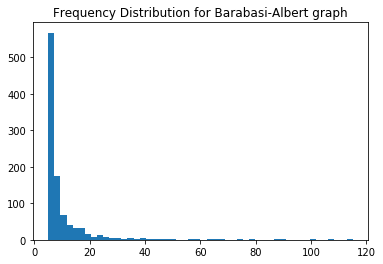

4975


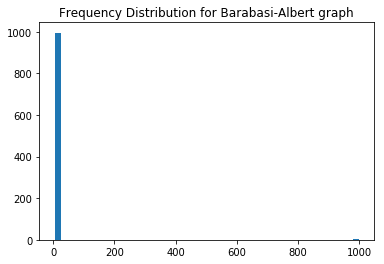

9900


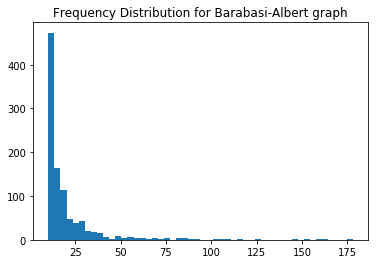

9900


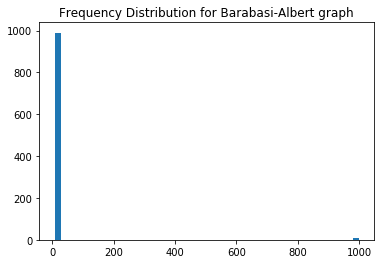

In [35]:
for _ in [(5, 995), (10, 990)]:
    ba = nx.barabasi_albert_graph(N_NODES, _[0])
    print(ba.number_of_edges())
    plot_distribution(ba, bins=50, label='Barabasi-Albert graph')
    ba = nx.barabasi_albert_graph(N_NODES, _[1])
    print(ba.number_of_edges())
    plot_distribution(ba, bins=50, label='Barabasi-Albert graph')

In [36]:
def solve_poly(a, b, c):
    # ax**2 + bx + c = 0
    # calculate the discriminant
    d = (b**2) - (4*a*c)
    # return two solutions
    return (-b - math.sqrt(d))/(2*a), (-b + math.sqrt(d))/(2*a)

# debug
a = 1
b = -1000
c = 4975
solve_poly(1, -1000, 4975)

(5.0, 995.0)

In [37]:
# sample function allowing to control for edge number
def create_barabasi_with_nodes_and_edges(n_nodes, n_edges):
    solutions = solve_poly(1, n_nodes * -1.0, n_edges)
    m = int(min(solutions))
    c_network = get_network_by_type_and_settings('barabasi', [n_nodes, m])
    # debug
    print(m, n_edges, c_network.number_of_edges(), solutions)
    return m, c_network

for _ in range (1000, 10000, 1000):
    m, c_network = create_barabasi_with_nodes_and_edges(N_NODES, _)
    assert abs(_ - c_network.number_of_edges()) < (_ * 0.05)

1 1000 999 (1.0010020050140156, 998.998997994986)
2 2000 1996 (2.004016080450697, 997.9959839195493)
3 3000 2991 (3.0090544084329167, 996.9909455915671)
4 4000 3984 (4.016129294510222, 995.9838707054898)
5 5000 4975 (5.025253169416715, 994.9747468305833)
6 6000 5964 (6.0364385908612235, 993.9635614091387)
7 7000 6951 (7.049698245350498, 992.9503017546494)
8 8000 7936 (8.065044950046286, 991.9349550499537)
9 9000 8919 (9.082491654656906, 990.9175083453431)
